# Reinforcement Learning for fine-tuning Diffusion Models tutorial notebook

## Table of content

>[1 Paper overview](#scrollTo=4c7_kL6zikv2)

>>[1.1 Diffusion model denoising process as Markov Decision Process](#scrollTo=5jN4kQTwikv2)

>[2 Simple Reinforcement Learning example](#scrollTo=xH8kfxiJikv2)

>>[2.1 RWR method](#scrollTo=n_dKPoDLikv4)

>>[2.2 DDPO method](#scrollTo=naviqha-ikv5)

>[3 Implementing RWR-Sparse](#scrollTo=n-YECjxEikv5)

>[4 Demonstration of the actual DDPO fine-tuned diffusion models](#scrollTo=ep89iW07ikwD)



<b> Created by: Davronbek Islamov</b><br>
Email: dais00002@stud.uni-saarland.de<br>
Matriculation number: 7039292

<b>References:</b><br>
Original paper: [Link](https://arxiv.org/pdf/2305.13301.pdf)<br>
This project uses tiny-diffusion model as the base model for training: [Link](https://github.com/tanelp/tiny-diffusion)

## 1 Paper overview

Authors of the paper propose to use Reinforcement Learning Techniques for fine-tuning Diffusion Models for use-cases which are otherwise difficult to optimize for. These use-cases might be generating more compressable images (to reduce the size of the output), more aethtetic images, allign the output with the prompt better, etc. In simple words, the concept is to imagine the image generation steps as part of the Markov Decision Process and use Reinforcement Learning to optimize the model for the desired outcome.

### 1.1 Diffusion model denoising process as Markov Decision Process

Image below shows how we can imagine the denoising step of Diffusion Models as Markov Decision Process. We start with the pure noise and consides each possible denoising step as a next state. Note that the image below is simplified, in reality there is a large number of states at each denosing step. You can think of it as all the permutation of the image after denoising. And the final state is the image we want to generate.

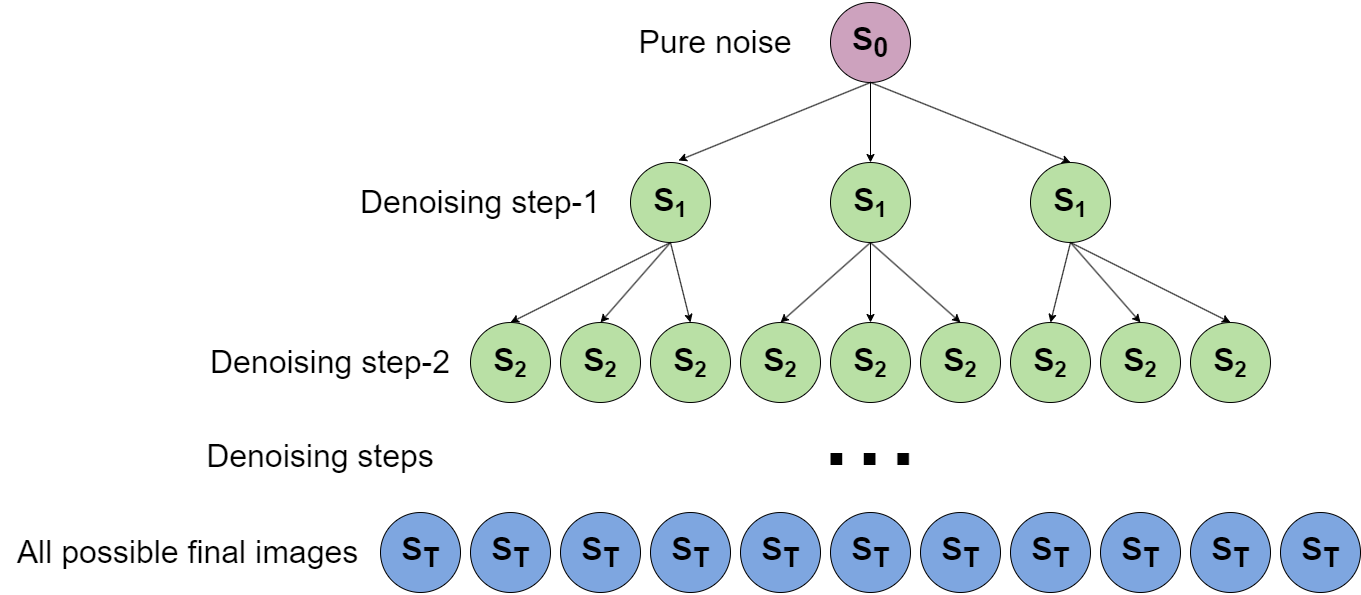

## 2 Simple Reinforcement Learning example

As we said before, in order to apply Reinforcement Learning to Diffusion Models, we need to imagine the denoising process as Markov Decision Process.
In this section we will have a look on a simple example of how reinforcement learning can be used for finding optimal trajectories in this Markov Decision Processes. This is useful because it then can be easily applied for diffusion models as optimization of the denoising process. We will use a game called Frozen Lake as an example. The game is very simple, an agent starts at the top of the map and proceeds down untill it reaches the goal and receives a positive reward. If the agent reaches a hole, it loses and receives negative reward.


This game is a part of 'gymnasium' python package, which is a convenient package with general RL problems. We will use it to play the game and see how training will change the path of our agent.

In [16]:
# Install gymnasium to access Frozen Lake game
!pip install gymnasium --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 9.1 MB/s eta 0:00:00


In [39]:
# Import dependencies

from matplotlib import pyplot as plt
import numpy as np
import gymnasium as gym

In [40]:
# Action sampler for example
def sample_action(state, last_action=3, field_size=7):
    if(state == field_size//2):
        return 1
    if(state%field_size == 0):
        if(last_action == 0):
            return 1
        return np.random.choice([1,2])
    elif(state%field_size == field_size-1):
        if(last_action == 2):
            return 1
        return np.random.choice([0,1])
    else:
        if(last_action == 0 or last_action == 2):
            return 1
        return np.random.choice([0,1,2])

In [41]:
# Functions to plot episodes
def draw_field(field, state_actions, field_size=7, draw = True):
    '''Plot the current field with arrows indicating the actions taken at each state.'''

    fig, ax = plt.subplots(figsize=(4, 4))
    ax.imshow(field, extent=[-0.5, 6.5, 6.5, -0.5])

    for state_action in state_actions:
        state = state_action[0]
        action = state_action[1]
        i = state // field_size
        j = state % field_size

        if action == 0:  # left
            ax.arrow(j, i, -0.3, 0, head_width=0.2, head_length=0.2, fc='r', ec='r')
        elif action == 1:  # down
            ax.arrow(j, i, 0, 0.3, head_width=0.2, head_length=0.2, fc='r', ec='r')
        elif action == 2:  # right
            ax.arrow(j, i, 0.3, 0, head_width=0.2, head_length=0.2, fc='r', ec='r')
        elif action == 3:  # up
            ax.arrow(j, i, 0, -0.3, head_width=0.2, head_length=0.2, fc='r', ec='r')
    if(draw):
        plt.show()

def draw_episode(episodes: tuple, fig_size = 5, field_size = 7) -> None:
    '''Plot the whole episode'''
    fig,axes = plt.subplots(2,5, figsize=(16, 8))
    for i, episode in enumerate(episodes):
        field = episode[0]
        state_actions = episode[1]

        x = i//fig_size
        y = i%fig_size
        ax = axes[x][y]

        ax.imshow(field, extent=[-0.5, 6.5, 6.5, -0.5])
        if(state_actions[-1][0] == 36 and state_actions[-1][1] == 1):
            ax.set_title(f'Episode {i+1}', color = 'green')
        else:
            ax.set_title(f'Episode {i+1}', color = 'red')
        for state_action in state_actions:
            state = state_action[0]
            action = state_action[1]
            x = state // field_size
            y = state % field_size

            if action == 0:  # left
                ax.arrow(y, x, -0.3, 0, head_width=0.2, head_length=0.2, fc='r', ec='r')
            elif action == 1:  # down
                ax.arrow(y, x, 0, 0.3, head_width=0.2, head_length=0.2, fc='r', ec='r')
            elif action == 2:  # right
                ax.arrow(y, x, 0.3, 0, head_width=0.2, head_length=0.2, fc='r', ec='r')
            elif action == 3:  # up
                ax.arrow(y, x, 0, -0.3, head_width=0.2, head_length=0.2, fc='r', ec='r')

    plt.show()

In [42]:
def init_policy(state_space):
    '''Initialize the policy randomly.'''
    policy = []
    for i in range(state_space):
        policy.append(sample_action(i))

    return np.array(policy)

Our action space {DOWN, LEFT, RIGHT}, but we cant go into the wall, so on the sides it is {DOWN, RIGHT} or {DOWN, LEFT}. Also, if we went left we cant go right, to avoid getting stuck in one place.

In [43]:
def play_random(env, draw = True):
    '''Play the game by taking random actions'''
    state_actions = []
    state, _ = env.reset()
    action = sample_action(state)
    field = env.render()
    done = False
    while not done:
        state_actions.append((state, action))
        state, reward, done, truncated, _ = env.step(action)
        field = env.render()
        action = sample_action(state, action)  # Use the current policy
        if(draw):
            f = draw_field(field, state_actions)

    return (field, state_actions)

def play(env, policy, draw = True):
    '''Play the game by following given policy'''
    state_actions = []
    state, _ = env.reset()
    action = policy[state]
    field = env.render()
    done = False
    while not done:
        state_actions.append((state, action))
        state, reward, done, truncated, _ = env.step(action)
        field = env.render()
        if(action == 0 and policy[state] == 2):
            action = 1
        elif(action == 2 and policy[state] == 0):
            action = 1
        else:
            action = policy[state]  # Use the current policy
        if(draw):
            draw_field(field, state_actions)

    return (field, state_actions)

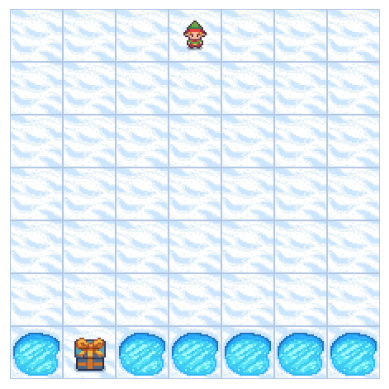

In [44]:
# Initialize the environment
desc=["FFFSFFF", "FFFFFFF", "FFFFFFF", "FFFFFFF", "FFffFFF", "FFFffFF", "HGHHHHH"]
env = gym.make('FrozenLake-v1', desc=desc, map_name="7x7", is_slippery=False, render_mode="rgb_array")
env.action_space.n = 3
# Show the environment
env.reset()
field = env.render()
plt.axis('off')
plt.imshow(field)
plt.show()

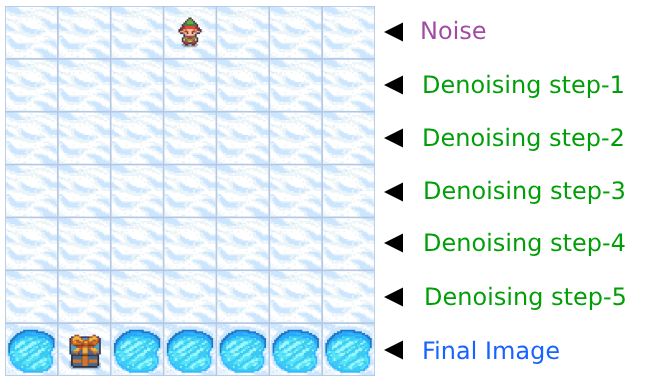

 We can imagine that the field is our denoising process, each step of the agent corresponds to a denoising step of a diffusion model. The goal is to find the optimal trajectory that will lead to the best denoising result. Let us consider a full example. Imagine we want to generate an artistic image of a cat. The top row is pure noise. Each step the agent takes, results in a slightly denoised image, as in Diffusion models backward process. If our agent turns wrong and end up in one of the holes then our final image is not artistic. If our agent reaches the present, then our model took the right denoising steps and ended up with an artisitic image of a cow.

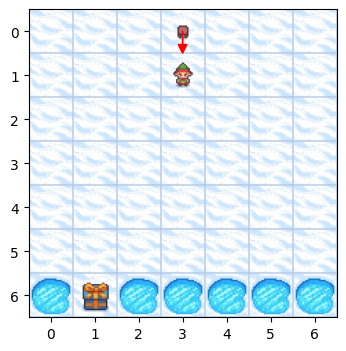

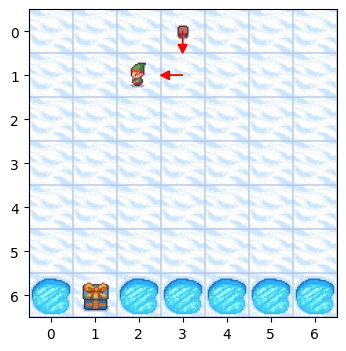

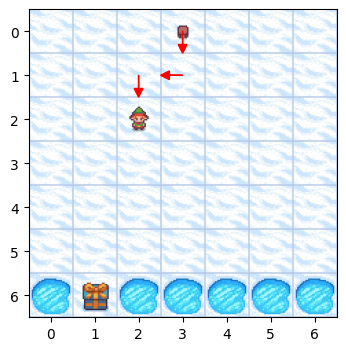

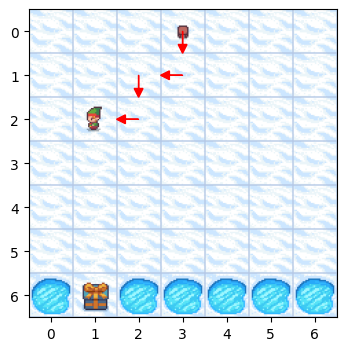

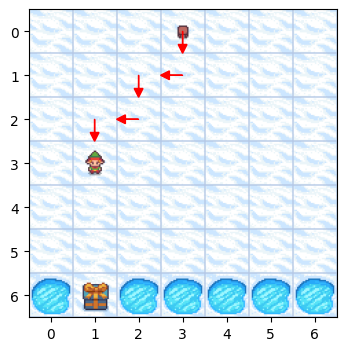

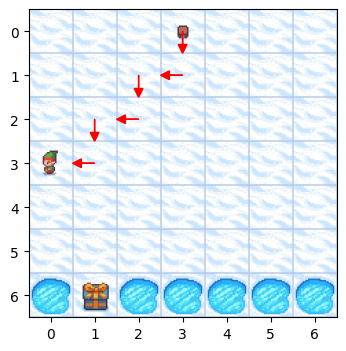

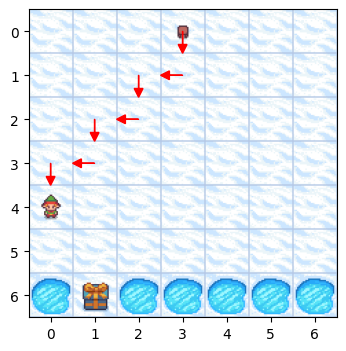

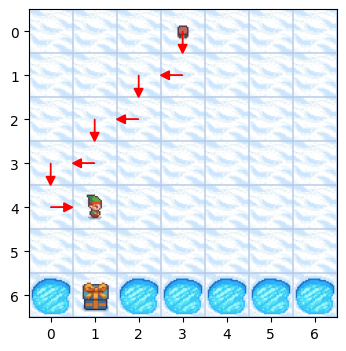

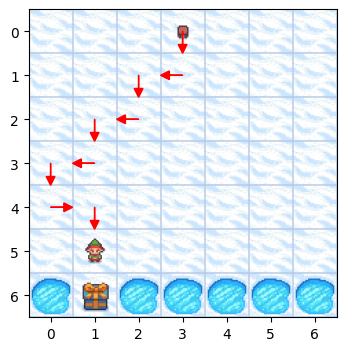

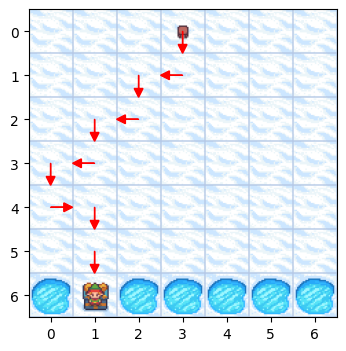

In [45]:
# Run to simulate the path
np.random.seed(0)
num_states = env.observation_space.n
policy = init_policy(num_states)

_ = play_random(env)

We can see that the path from noise to the final image has its own trajectory (or deneosing steps). The goal of reinforcement learning is to maximize the total reward by optimizing the trajectory to the goal. This reward is a function that we choose. For example if we want our model to produce more compressable output, we can choose the negative of the image size as a reward. Then the models which produce more compressable images will get higher rewards.

So our learning objective is:

$$
J_{DDRL}(\theta) = E[r(x_0,c)]
$$

### 2.1 RWR method

One of the two proposed methods in the paper is Reward Weighted Regression. This method adds weights to a standard Diffusion model training objective, giving more weight to the changes that favors some predefined reward function. For example, the reward can be the revese of size of the output if we are training for compressability and etc. They also define Sparse version of this method, RWR-Sparse, which only changes the model weights if the reward is higher than some threshold $C$.

$$w_{RWR}(x_0,c) = \frac{1}{Z} exp(\beta r(x_0, c))$$
Where:<br>
  - Z - normalization constant<br>
  - $\beta$ - inverse temperature
$$w_{Sparse}(x_0,c) = 1[r(x_0,c) \geq C]$$

Where:<br>
- C - some threshold

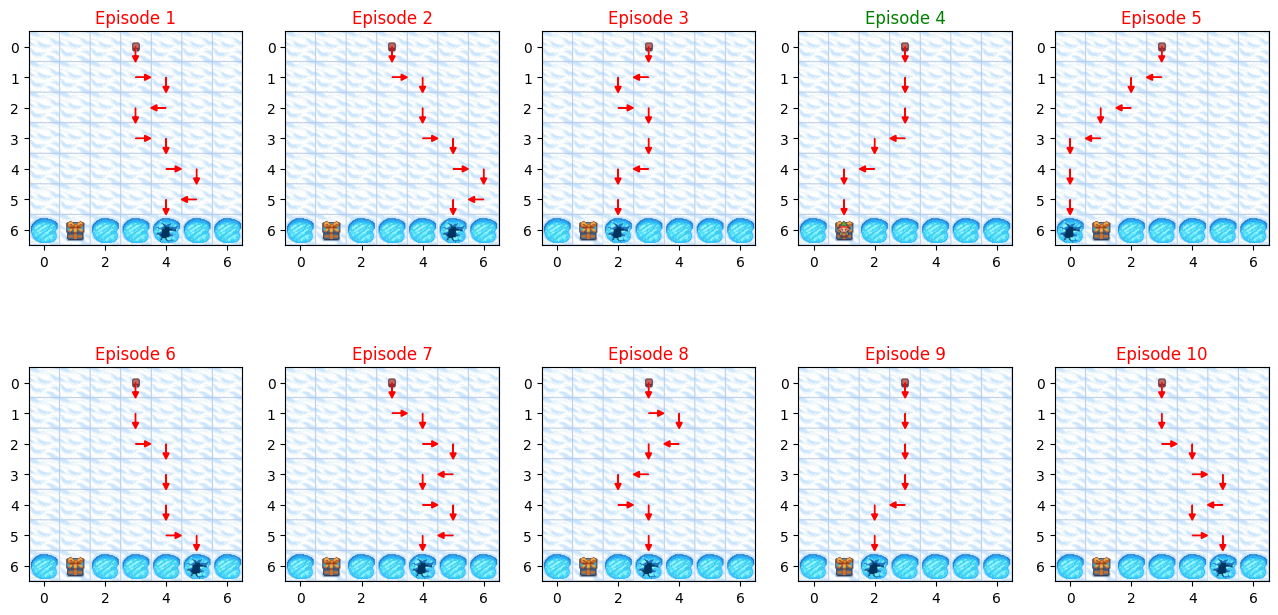

In [46]:
np.random.seed(42)
episodes = []
for i in range(10):
    field, state_actions = play_random(env, draw=False)
    episodes.append((field, state_actions))

draw_episode(episodes)

Remember that with RWR method only episodes that got reward contribute to the model parameter update. Above we run several episodes of the game, which you can imagine as a diffusion model image generation. Each episode corresponds to a single image being generated. Episodes marked with green contribute to the model parameter update, while the red ones do not. In this particular example, only Episode 4 would contribute to the model parameters update. We can see that it is very ineffective as the sample space is very huge and getting the correct result just by chance is very unlikely.

### 2.2 DDPO method

Denoising Diffusion Policy Optimization (DDPO) is another method proposed in paper, aimed to solve the problems of RWR. Despite RWR, which only looks at the final result to decide how to change weights, DDPO keeps track of every denoising step the model makes to reach the final image. Then it maximizes the probability of denoising steps that contributed more in reaching the desired output.

DDPO gradient update:
$$\nabla_\theta J_{DDRL} = E\left[ \sum^T_{t=0}\nabla_\theta log p_\theta(x_{t-1}|x_t,c)r(x_0,c) \right]$$

You can see that the gradient keeps track of $log p_\theta(x_{t-1}|x_t,c)$ which is the probability of taking some particular denoising step.

As DDPO is complex algorithm, below I am using simpler Reinforcement Learning algorithm, called Moine-Carlo Control, to give an idea of how DDPO would work with Denoising step of Diffusion Models. The goal is to see that we can guide our agent into the right direction and increase the probability of taking the right action. Later we can use the DDPO objective to fine-tune model parameters in similar manner.

In [47]:
def improve(policy, num_iterations=1):
    '''Simple Monte-Carlo control training algorithm'''
    num_states = env.observation_space.n
    num_actions = env.action_space.n

    # Hyperparameters
    gamma = 0.9
    num_episodes = 100
    epsilon = 0.1
    Q = np.zeros([num_states, num_actions])

    for iteration in range(num_iterations):
        episode_count = 0

        returns = {}
        count = {}

        # Run policy evaluation
        while episode_count < num_episodes:
            state, _ = env.reset()
            episode = []
            truncated = False
            done = False

            while not (truncated or done):
                # We take a random action with small probability to prevent stucking at one cell
                if(np.random.rand() < epsilon):
                    action = np.random.choice(num_actions)
                else:
                    action = policy[state]

                new_state, reward, done, truncated, _ = env.step(action)
                episode.append((state, action, reward))
                state = new_state

            episode_count += 1

            acc_return = 0
            visited_pairs = set()

            for t in reversed(range(len(episode))):
                s, a, r = episode[t]

                if (s, a) not in visited_pairs:
                    visited_pairs.add((s, a))
                    acc_return = r + gamma * acc_return
                    if (s, a) not in returns:
                        returns[(s, a)] = 0
                        count[(s, a)] = 0

                    returns[(s, a)] += acc_return
                    count[(s, a)] += 1

        # Update our action values
        for (s, a), total_return in returns.items():
            Q[s, a] = Q[s, a]+ 1 / count[(s, a)]*(total_return - Q[s, a])

        # Policy improvement, by taking actions with max reward
        for state in range(num_states):
            best_actions = np.argwhere(Q[state] == np.amax(Q[state])).flatten()
            policy[state] = np.random.choice(best_actions)

            # Check to prevent the agent from getting stuck in a loop
            if(state % 7 == 6 and policy[state] == 2):
                policy[state] = 1
            elif(state % 7 == 0 and policy[state] == 0):
                policy[state] = 1

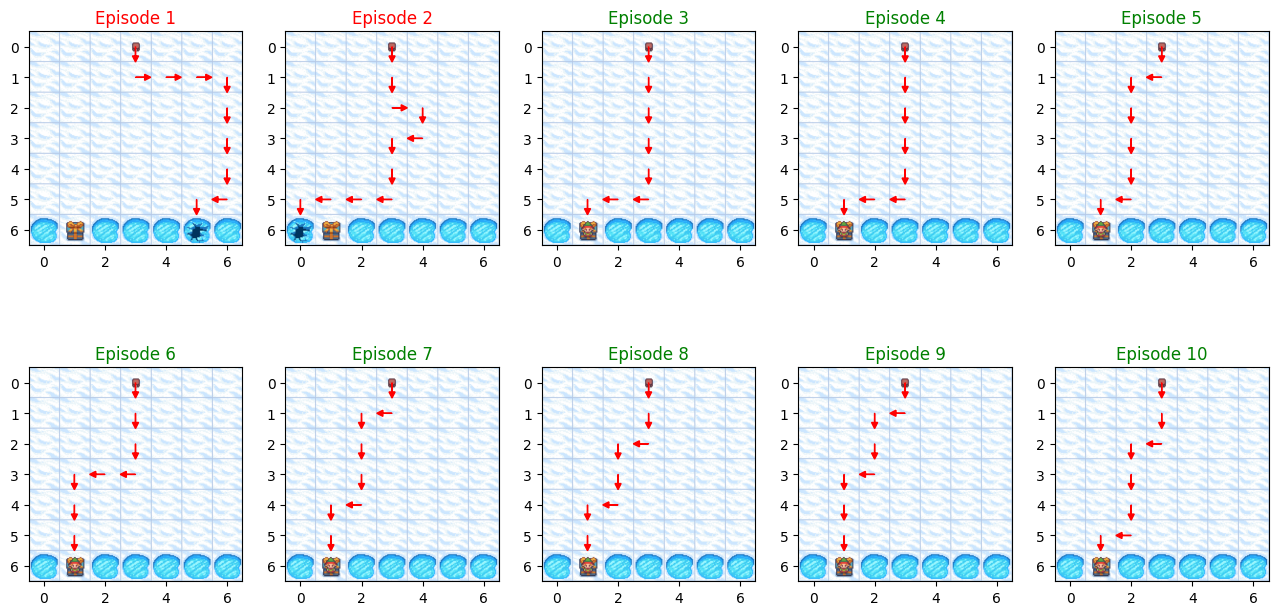

In [48]:
np.random.seed(42)
policy = init_policy(num_states)
episodes = []

for i in range(10):
    field, state_actions = play(env, policy, False)
    episodes.append((field, state_actions))
    improve(policy, 1)

draw_episode(episodes)

You can see that the model fails in the first episodes, but learns the optimal trajectory with time. And it is a lot more effective than RWR, becuase we do not hope to get the right result, but actually push the model in the right direction. In this particular example, it converges very quickly as the example is very simple, but in real diffusion models it takes a lot of time and resources to fine-tune.

## 3 Implementing RWR-Sparse

In this section we implement a simple RWR fine-tuning of a tiny diffusion model. This model generates the dataset that looks like a dinosaur. Our fine-tuned model will be penalized for drawing hands in the dinosaur.<br>
The reward function is:
$$R = \frac{50}{n + 1}$$
Where <b>n</b> is number of points inside hand area rectangle.<br>
So if we have 0 points there, which is the ideal case, our reward will be 50. For every point inside, the reward reduces exponentially. We can select 49 as our threshold for RWR-sparse algorithm, which means only results with no points in the region contribute to the weights update.
We then, compare these two models and compare their rewards.

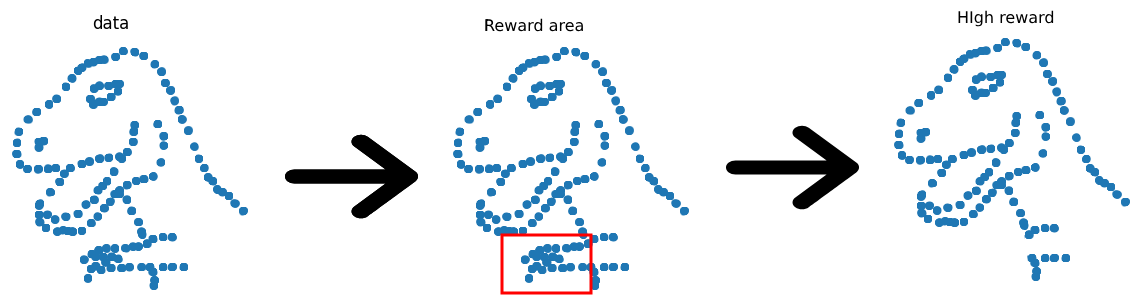

In [49]:
import torch
import numpy as np
import math
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
from torch import nn
from torch.nn import functional as F

import os
import requests
import io

import urllib.request
import os
from pathlib import Path

In [50]:
# Helper functions

def dino_dataset():
    '''Load the Dino dataset and return it as a TensorDataset.'''

    df = pd.read_csv("datasets/DatasaurusDozen.tsv", sep="\t")
    df = df[df["dataset"] == "dino"]

    rng = np.random.default_rng(42)
    ix = rng.integers(0, len(df), 8000)
    x = df["x"].iloc[ix].tolist()
    x = np.array(x) + rng.normal(size=len(x)) * 0.15
    y = df["y"].iloc[ix].tolist()
    y = np.array(y) + rng.normal(size=len(x)) * 0.15
    x = (x/54 - 1) * 4
    y = (y/48 - 1) * 4
    X = np.stack((x, y), axis=1)
    return TensorDataset(torch.from_numpy(X.astype(np.float32)))


def sample_from_model(model, noise_scheduler, num_timesteps=50, eval_batch_size=1000):
    '''Sample from the model using the noise scheduler.'''
    timesteps = list(range(num_timesteps))[::-1]
    sample = torch.randn(eval_batch_size, 2)
    for i, t in enumerate(timesteps):
        t = torch.from_numpy(np.repeat(t, eval_batch_size)).long()
        with torch.no_grad():
            residual = model(sample, t)
        sample = noise_scheduler.step(residual, t[0], sample)
    return sample

def reward(sample):
    '''Count how many points are between -1 and 1 on x and -4 and -2 on y (hands of the dinosaur region)'''
    x = sample[:, 0]
    y = sample[:, 1]
    x_in = (x > -1) & (x < 1)
    y_in = (y > -3) & (y < -2)
    points_on_hands = (x_in & y_in).sum()
    return 50/(points_on_hands+1)


In [52]:
# Definition of classes to train the model

# Different embeddings
class SinusoidalEmbedding(nn.Module):
    def __init__(self, size: int, scale: float = 1.0):
        super().__init__()
        self.size = size
        self.scale = scale

    def forward(self, x: torch.Tensor):
        x = x * self.scale
        half_size = self.size // 2
        emb = torch.log(torch.Tensor([10000.0])) / (half_size - 1)
        emb = torch.exp(-emb * torch.arange(half_size))
        emb = x.unsqueeze(-1) * emb.unsqueeze(0)
        emb = torch.cat((torch.sin(emb), torch.cos(emb)), dim=-1)
        return emb

    def __len__(self):
        return self.size


# Noise scheduler
class NoiseScheduler():
    def __init__(self,
                 num_timesteps=1000,
                 beta_start=0.0001,
                 beta_end=0.02,
                 beta_schedule="linear"):

        self.num_timesteps = num_timesteps
        if beta_schedule == "linear":
            self.betas = torch.linspace(
                beta_start, beta_end, num_timesteps, dtype=torch.float32)
        elif beta_schedule == "quadratic":
            self.betas = torch.linspace(
                beta_start ** 0.5, beta_end ** 0.5, num_timesteps, dtype=torch.float32) ** 2

        self.alphas = 1.0 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, axis=0)
        self.alphas_cumprod_prev = F.pad(
            self.alphas_cumprod[:-1], (1, 0), value=1.)

        # required for self.add_noise
        self.sqrt_alphas_cumprod = self.alphas_cumprod ** 0.5
        self.sqrt_one_minus_alphas_cumprod = (1 - self.alphas_cumprod) ** 0.5

        # required for reconstruct_x0
        self.sqrt_inv_alphas_cumprod = torch.sqrt(1 / self.alphas_cumprod)
        self.sqrt_inv_alphas_cumprod_minus_one = torch.sqrt(
            1 / self.alphas_cumprod - 1)

        # required for q_posterior
        self.posterior_mean_coef1 = self.betas * torch.sqrt(self.alphas_cumprod_prev) / (1. - self.alphas_cumprod)
        self.posterior_mean_coef2 = (1. - self.alphas_cumprod_prev) * torch.sqrt(self.alphas) / (1. - self.alphas_cumprod)

    def reconstruct_x0(self, x_t, t, noise):
        s1 = self.sqrt_inv_alphas_cumprod[t]
        s2 = self.sqrt_inv_alphas_cumprod_minus_one[t]
        s1 = s1.reshape(-1, 1)
        s2 = s2.reshape(-1, 1)
        return s1 * x_t - s2 * noise

    def q_posterior(self, x_0, x_t, t):
        s1 = self.posterior_mean_coef1[t]
        s2 = self.posterior_mean_coef2[t]
        s1 = s1.reshape(-1, 1)
        s2 = s2.reshape(-1, 1)
        mu = s1 * x_0 + s2 * x_t
        return mu

    def get_variance(self, t):
        if t == 0:
            return 0

        variance = self.betas[t] * (1. - self.alphas_cumprod_prev[t]) / (1. - self.alphas_cumprod[t])
        variance = variance.clip(1e-20)
        return variance

    def step(self, model_output, timestep, sample):
        t = timestep
        pred_original_sample = self.reconstruct_x0(sample, t, model_output)
        pred_prev_sample = self.q_posterior(pred_original_sample, sample, t)

        variance = 0
        if t > 0:
            noise = torch.randn_like(model_output)
            variance = (self.get_variance(t) ** 0.5) * noise

        pred_prev_sample = pred_prev_sample + variance

        return pred_prev_sample

    def add_noise(self, x_start, x_noise, timesteps):
        s1 = self.sqrt_alphas_cumprod[timesteps]
        s2 = self.sqrt_one_minus_alphas_cumprod[timesteps]

        s1 = s1.reshape(-1, 1)
        s2 = s2.reshape(-1, 1)

        return s1 * x_start + s2 * x_noise

    def __len__(self):
        return self.num_timesteps

class Block(nn.Module):
    def __init__(self, size: int):
        super().__init__()

        self.ff = nn.Linear(size, size)
        self.act = nn.GELU()

    def forward(self, x: torch.Tensor):
        return x + self.act(self.ff(x))


# Our diffusion model
class MLP(nn.Module):
    def __init__(self, hidden_size: int = 128, hidden_layers: int = 3, emb_size: int = 128):
        super().__init__()

        self.time_mlp = SinusoidalEmbedding(emb_size)
        self.input_mlp1 = SinusoidalEmbedding(emb_size, scale=25.0)
        self.input_mlp2 = SinusoidalEmbedding(emb_size, scale=25.0)

        concat_size = len(self.time_mlp) + \
            len(self.input_mlp1) + len(self.input_mlp2)
        layers = [nn.Linear(concat_size, hidden_size), nn.GELU()]
        for _ in range(hidden_layers):
            layers.append(Block(hidden_size))
        layers.append(nn.Linear(hidden_size, 2))
        self.joint_mlp = nn.Sequential(*layers)

    def forward(self, x, t):
        x1_emb = self.input_mlp1(x[:, 0])
        x2_emb = self.input_mlp2(x[:, 1])
        t_emb = self.time_mlp(t)
        x = torch.cat((x1_emb, x2_emb, t_emb), dim=-1)
        x = self.joint_mlp(x)
        return x

In [53]:
# Download a Dino dataset

if(not os.path.exists("datasets/DatasaurusDozen.tsv")):
  Path("datasets").mkdir(parents=True, exist_ok=True)

  dataset_retriever = urllib.request.URLopener()
  dataset_retriever.retrieve("https://raw.githubusercontent.com/IDavron/RWR/master/datasets/DatasaurusDozen.tsv", "datasets/DatasaurusDozen.tsv")

In [54]:
# Initialize the dataset, model, and optimizer

batch_size = 32

dataset = dino_dataset()
dataloader = DataLoader(
    dataset, batch_size=batch_size, shuffle=True, drop_last=True)


hidden_size = 128
hidden_layers = 3
embedding_size = 128
time_embedding = "sinusoidal"
input_embedding = "sinusoidal"

model = MLP(
    hidden_size=hidden_size,
    hidden_layers=hidden_layers,
    emb_size=embedding_size
    )


num_timesteps = 50
beta_schedule = "linear"

noise_scheduler = NoiseScheduler(
    num_timesteps=num_timesteps,
    beta_schedule=beta_schedule)


learning_rate = 1e-3

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=learning_rate,
)


Now when we defined everything we need, we can see how the forward process work.

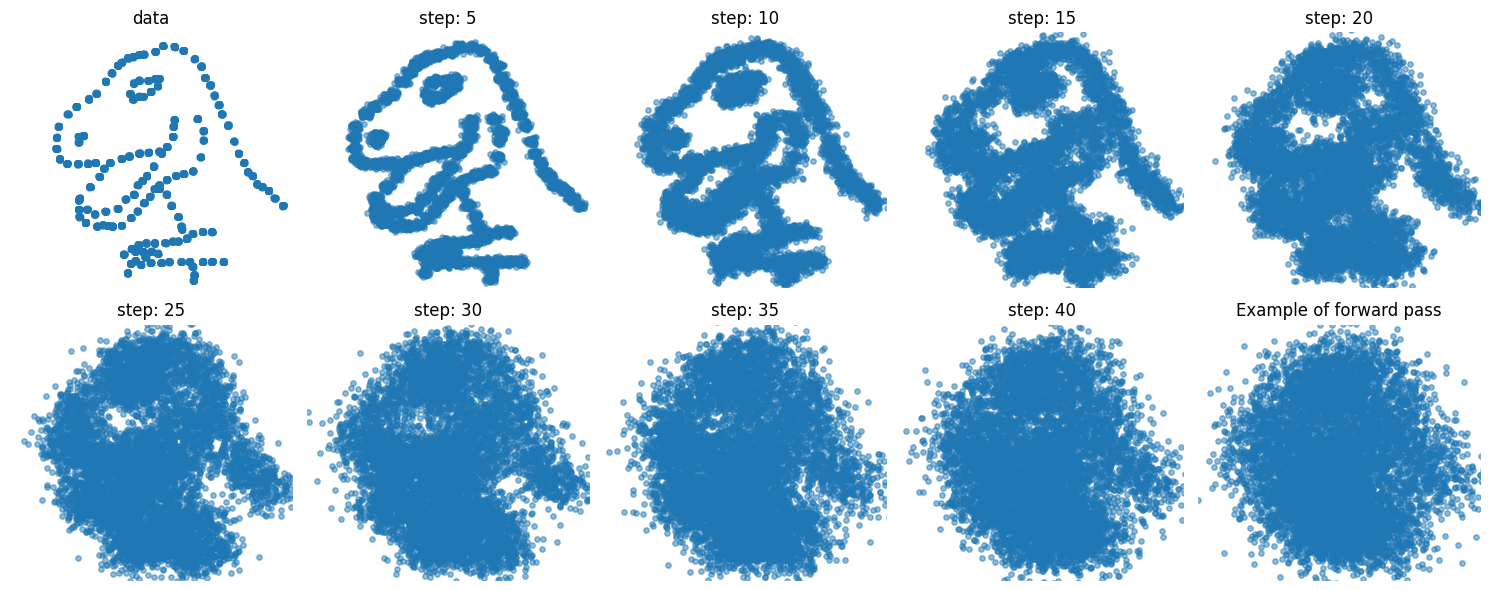

In [55]:
# Example of forward pass

num_timesteps = 50
plot_step = 5

num_plots = math.ceil(num_timesteps / plot_step)
num_cols = 5
num_rows = math.ceil(num_plots / num_cols)

fig = plt.figure(figsize=(15, 6))

x0 = dataset.tensors[0]

plt_cnt = 1
plt.subplot(num_rows, num_cols, plt_cnt)
plt.scatter(x0[:, 0], x0[:, 1], alpha=0.5, s=15)
plt.title("data")
plt.xlim(-3.5, 3.5)
plt.ylim(-4., 4.75)
plt.axis("off")

for t in range(len(noise_scheduler)):
    timesteps = np.repeat(t, len(x0))
    noise = torch.randn_like(x0)
    sample = noise_scheduler.add_noise(x0, noise, timesteps)
    if (t + 1) % plot_step == 0 and (t + 1) != len(noise_scheduler):
        plt_cnt += 1
        plt.subplot(num_rows, num_cols, plt_cnt)
        plt.scatter(sample[:, 0], sample[:, 1], alpha=0.5, s=15)
        plt.title(f"step: {t + 1}")
        plt.xlim(-3.5, 3.5)
        plt.ylim(-4., 4.75)
        plt.axis("off")

fig.tight_layout()
plt.title("Example of forward pass")
plt.show()

Next step is to train our models. We train three models:<br>
- Base model<br>
- Fine-tuned base model<br>
- Fine-tuned model from scratch

Code below contain blocks where we train our models and save weights into a folder. If you dont want to wait for the models to train, you can just run the next block and it will download all models' weights, so you can just use them.

In [59]:
# If you don't want to train models, code below will download weights. Just ignore training code blocks after that.

if(not os.path.exists("models")):
  Path("models").mkdir(parents=True, exist_ok=True)

if(not os.path.exists("models/model.pth")):
  weights_retriever = urllib.request.URLopener()
  weights_retriever.retrieve("https://raw.githubusercontent.com/IDavron/RWR/master/models/model.pth", "models/model.pth")

if(not os.path.exists("models/model_finetuned.pth")):
  weights_retriever = urllib.request.URLopener()
  weights_retriever.retrieve("https://raw.githubusercontent.com/IDavron/RWR/master/models/model_finetuned.pth", "models/model_finetuned.pth")

if(not os.path.exists("models/model_finetuned_fresh.pth")):
  weights_retriever = urllib.request.URLopener()
  weights_retriever.retrieve("https://raw.githubusercontent.com/IDavron/RWR/master/models/model_finetuned_fresh.pth", "models/model_finetuned_fresh.pth")

In [56]:
# Training the base model

torch.manual_seed(0)
num_epochs = 200
eval_batch_size = 1000
losses = []

print("Training model...")
for epoch in tqdm(range(num_epochs)):
    model.train()
    for step, batch in enumerate(dataloader):
        batch = batch[0]
        batch
        noise = torch.randn(batch.shape)
        timesteps = torch.randint(
            0, noise_scheduler.num_timesteps, (batch.shape[0],)
        ).long()

        noisy = noise_scheduler.add_noise(batch, noise, timesteps)
        noise_pred = model(noisy, timesteps)
        loss = F.mse_loss(noise_pred, noise)
        loss.backward(loss)

        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        optimizer.zero_grad()

        losses.append(loss.detach().item())


print("Saving model...")
outdir = "models"
os.makedirs(outdir, exist_ok=True)
torch.save(model.state_dict(), f"{outdir}/model.pth")

print("Saving loss as numpy array...")
np.save(f"{outdir}/loss.npy", np.array(losses))


Training model...


  0%|          | 0/200 [00:00<?, ?it/s]

Saving model...
Saving loss as numpy array...


Now we can load the base model and look how it performs

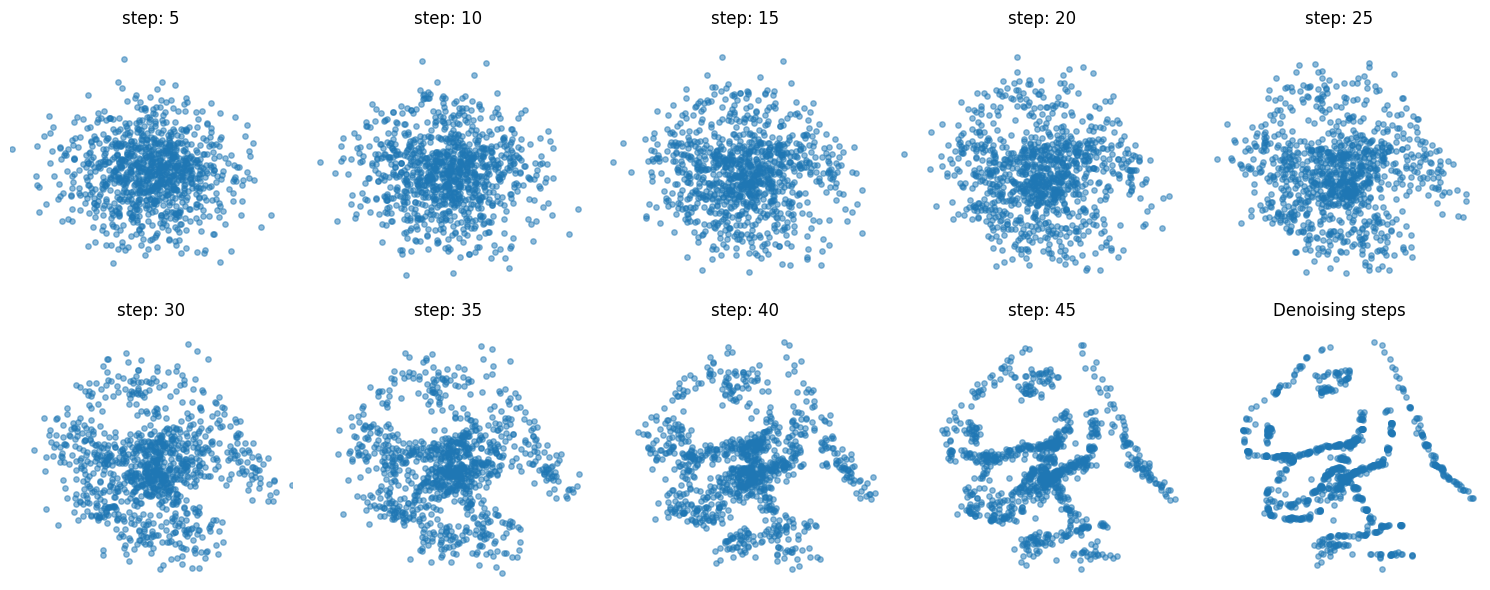

In [58]:
# Demonstration of the trained model
model = MLP()
path = "models/model.pth"
model.load_state_dict(torch.load(path))
model.eval()

plot_step = 5
noise_scheduler = NoiseScheduler(num_timesteps=num_timesteps)
sample = torch.randn(eval_batch_size, 2)
timesteps = list(range(num_timesteps))[::-1]
samples = []
steps = []
for i, t in enumerate(timesteps):
    t = torch.from_numpy(np.repeat(t, eval_batch_size)).long()
    with torch.no_grad():
        residual = model(sample, t)
    sample = noise_scheduler.step(residual, t[0], sample)
    if (i + 1) % plot_step == 0:
        samples.append(sample.numpy())
        steps.append(i + 1)

num_cols = 5
num_rows = math.ceil(len(samples) / num_cols)
fig = plt.figure(figsize=(15, 6))
for i, sample in enumerate(samples):
    plt.subplot(num_rows, num_cols, i + 1)
    plt.scatter(sample[:, 0], sample[:, 1], alpha=0.5, s=15)
    plt.title(f"step: {steps[i]}")
    plt.xlim(-3.5, 3.5)
    plt.ylim(-4., 4.75)
    plt.axis("off")
fig.tight_layout()
plt.savefig("reverse.png", facecolor="white")
plt.title("Denoising steps")
plt.show()

Next we train the two remaining models. Because RWR method updates weights only in the reward is high that a threshold, we need a significantly more epochs to fine-tune as only a small protion of the samples will contribute to the training.

In [ ]:
# Fine-tuning the pre-trained model

model_finetuned = MLP()
path = "models/model.pth"
model_finetuned.load_state_dict(torch.load(path))

optimizer = torch.optim.AdamW(
    model_finetuned.parameters(),
    lr=learning_rate,
)

torch.manual_seed(0)
# We need to train more becuase we skip most of the batches
num_epochs = 2000

print("Training model...")
noises = []
for epoch in tqdm(range(num_epochs)):
    model_finetuned.train()
    for step, batch in enumerate(dataloader):
        batch = batch[0]
        noise = torch.randn(batch.shape)
        timesteps = torch.from_numpy(np.repeat(np.random.randint(0,50), 32)).long()

        noisy = noise_scheduler.add_noise(batch, noise, timesteps)
        noise_pred = model_finetuned(noisy, timesteps)
        loss = F.mse_loss(noise_pred, noise)
        loss.backward(loss)

        # We only train model if it receives high enough reward
        sample = noise_scheduler.step(noise_pred, timesteps[0], noisy)
        g = reward(sample)
        if(g > 49):
            nn.utils.clip_grad_norm_(model_finetuned.parameters(), 1.0)
            optimizer.step()
        optimizer.zero_grad()



print("Saving model...")
outdir = f"models"
os.makedirs(outdir, exist_ok=True)
torch.save(model_finetuned.state_dict(), f"{outdir}/model_finetuned.pth")


Training model...


  0%|          | 0/2000 [00:00<?, ?it/s]

Saving model...


In [ ]:
# Training model from scratch with RWR

hidden_size = 128
hidden_layers = 3
embedding_size = 128

model_finetuned_fresh = MLP(
    hidden_size=hidden_size,
    hidden_layers=hidden_layers,
    emb_size=embedding_size
    )

optimizer = torch.optim.AdamW(
    model_finetuned_fresh.parameters(),
    lr=learning_rate,
)

torch.manual_seed(0)
# We need to train more becuase we skip most of the batches
num_epochs = 4000

print("Training model...")
for epoch in tqdm(range(num_epochs)):
    model_finetuned_fresh.train()
    for step, batch in enumerate(dataloader):
        batch = batch[0]
        noise = torch.randn(batch.shape)
        timesteps = torch.from_numpy(np.repeat(np.random.randint(0,50), 32)).long()

        noisy = noise_scheduler.add_noise(batch, noise, timesteps)
        noise_pred = model_finetuned_fresh(noisy, timesteps)
        loss = F.mse_loss(noise_pred, noise)
        loss.backward(loss)

        # We only train model if it receives high enough reward
        sample = noise_scheduler.step(noise_pred, timesteps[0], noisy)
        g = reward(sample)
        if(g > 49):
            nn.utils.clip_grad_norm_(model_finetuned_fresh.parameters(), 1.0)
            optimizer.step()

        optimizer.zero_grad()



print("Saving model...")
outdir = f"models"
os.makedirs(outdir, exist_ok=True)
torch.save(model_finetuned_fresh.state_dict(), f"{outdir}/model_finetuned_fresh.pth")

Training model...


  0%|          | 0/4000 [00:00<?, ?it/s]

Saving model...


Now, when we have all three models we can sample outputs from each of them and see how they perform.

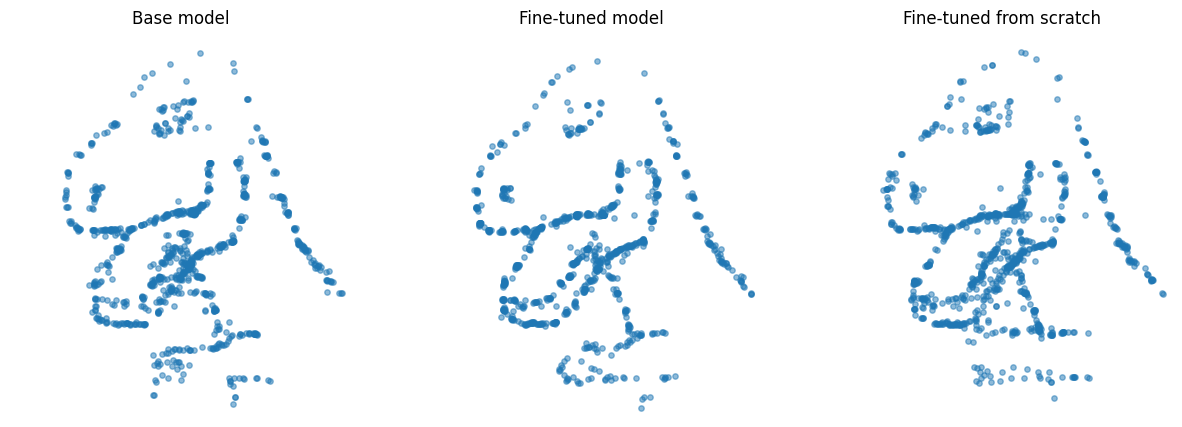

In [60]:
torch.manual_seed(0)
model = MLP()
path = "models/model.pth"
model.load_state_dict(torch.load(path))
model.eval()
base_sample = sample_from_model(model, noise_scheduler)

model_finetuned = MLP()
path = "models/model_finetuned.pth"
model_finetuned.load_state_dict(torch.load(path))
model_finetuned.eval()
finetuned_sample = sample_from_model(model_finetuned, noise_scheduler)

model_finetuned_fresh = MLP()
path = "models/model_finetuned_fresh.pth"
model_finetuned_fresh.load_state_dict(torch.load(path))
model_finetuned_fresh.eval()
finetuned_fresh_sample = sample_from_model(model_finetuned_fresh, noise_scheduler)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].scatter(base_sample[:, 0], base_sample[:, 1], alpha=0.5, s=15)
axes[0].set_title("Base model")
axes[0].set_xlim(-3.5, 3.5)
axes[0].set_ylim(-4., 4.75)
axes[0].axis("off")
axes[1].scatter(finetuned_sample[:, 0], finetuned_sample[:, 1], alpha=0.5, s=15)
axes[1].set_title("Fine-tuned model")
axes[1].set_xlim(-3.5, 3.5)
axes[1].set_ylim(-4., 4.75)
axes[1].axis("off")
axes[2].scatter(finetuned_fresh_sample[:, 0], finetuned_fresh_sample[:, 1], alpha=0.5, s=15)
axes[2].set_title("Fine-tuned from scratch")
axes[2].set_xlim(-3.5, 3.5)
axes[2].set_ylim(-4., 4.75)
axes[2].axis("off")
plt.show()

The effect of our reward based training might not be very clear, as RWR is not very optimal at teaching the model the desired output. We can see that change in fine-tuning the pre-trained model is not very noticable. For the model trained from scratch however, we can see that its hands area is not clearly defined. This is the effect of our reward, which encourages the model to not draw points at this region, so the model does not learn how to draw hands clearly. It is more clear if we look at the average rewards collected by each of these models.

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

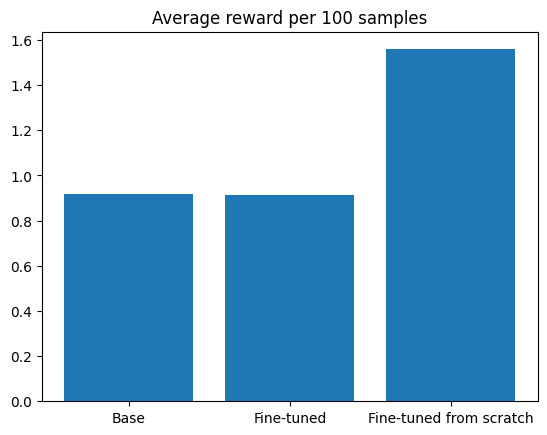

In [ ]:
# Define our 3 models and compare average rewards between them

model = MLP()
path = "models/model.pth"
model.load_state_dict(torch.load(path))
model.eval()

model_finetuned = MLP()
path = "models/model_finetuned.pth"
model_finetuned.load_state_dict(torch.load(path))
model_finetuned.eval()

model_finetuned_fresh = MLP()
path = "models/model_finetuned_fresh.pth"
model_finetuned_fresh.load_state_dict(torch.load(path))
model_finetuned_fresh.eval()

T = 100
torch.manual_seed(0)
average_reward_base = 0
for i in tqdm(range(T)):
    sample = sample_from_model(model, noise_scheduler)
    average_reward_base += reward(sample)

average_reward_base /= T

average_reward_finetuned = 0
for i in tqdm(range(T)):
    sample = sample_from_model(model_finetuned, noise_scheduler)
    average_reward_finetuned += reward(sample)

average_reward_finetuned /= T

average_reward_finetuned_fresh = 0
for i in tqdm(range(T)):
    sample = sample_from_model(model_finetuned_fresh, noise_scheduler)
    average_reward_finetuned_fresh += reward(sample)

average_reward_finetuned_fresh /= T

plt.bar(["Base", "Fine-tuned", "Fine-tuned from scratch"],
        [average_reward_base, average_reward_finetuned, average_reward_finetuned_fresh])
plt.title(f"Average reward per {T} samples")
plt.show()

We can see that fine-tuning pre-trained model, basically did not improved our reward in this case. However training with weight from scratch resulted in the model achieving higher reward consistently among these models.

## 4 Demonstration of the actual DDPO fine-tuned diffusion models

Training actual big diffusion model requires a huge amount of resources. However we can load the actual model weights for inference and see how it would look like if these methods were applied into an actual diffusion model. Below you can try actual big diffusion models which are fine tuned to produce aesthetic results using DDPO algorithm. We can see that for the same prompt we get very different results. Our fine-tuned model produces more painting like results, while regular stable diffusion produces more realistic ones.

In [ ]:
!pip install diffusers["torch"] transformers --quiet
!pip install accelerate --quiet

In [ ]:
from diffusers import DiffusionPipeline
from diffusers import StableDiffusionPipeline

In [ ]:
ddpo = DiffusionPipeline.from_pretrained("kvablack/ddpo-aesthetic")
stable_diffusion = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
safety_checker/model.safetensors not found


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

The config attributes {'use_memory_efficient_attention': False} were passed to UNet2DConditionModel, but are not expected and will be ignored. Please verify your config.json configuration file.
/usr/local/lib/python3.10/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py:199: FutureWarning: The configuration file of this scheduler: DDIMScheduler {
  "_class_name": "DDIMScheduler",
  "_diffusers_version": "0.27.1",
  "beta_end": 0.012,
  "beta_schedule": "scaled_linear",
  "beta_start": 0.00085,
  "clip_sample": true,
  "clip_sample_range": 1.0,
  "dynamic_thresholding_ratio": 0.995,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "rescale_betas_zero_snr": false,
  "sample_max_value": 

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

(…)kpoints/scheduler_config-checkpoint.json:   0%|          | 0.00/209 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

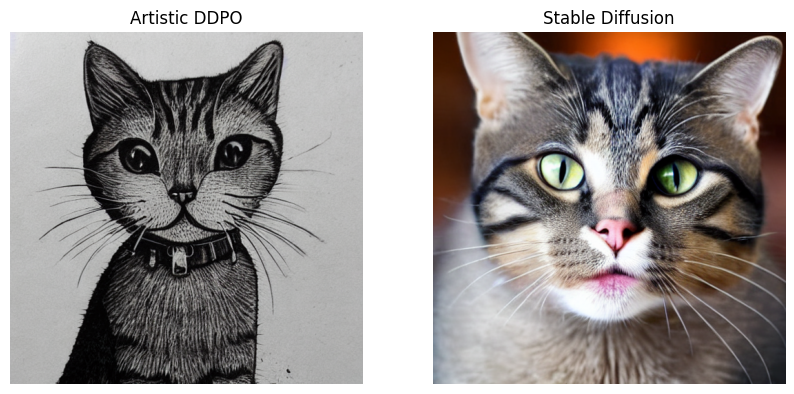

In [ ]:
torch.manual_seed(42)
prompt = "a cat"
image_1 = ddpo(prompt).images[0]
image_2 = stable_diffusion(prompt).images[0]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(image_1)
axes[0].axis("off")
axes[0].set_title("Artistic DDPO")
axes[1].imshow(image_2)
axes[1].axis("off")
axes[1].set_title("Stable Diffusion")
plt.show()